In [1]:
import numpy as np
import pandas as pd
import os
from tqdm import tqdm
import torch
import torch.nn as nn

from train_evaluate import NMR_prediction
import torch.nn.functional as F
import dgl
import dgl.nn as dglnn
import torch.nn as nn
from dgl import AddSelfLoop
from model_zoo.NMR_gcn import NMR_GCN
from create_graph_data_experiment import create_graph_experiment
from node_embeddings import create_node_embeddings
from create_adjaency_matrix_from_labeled_pdb import build_adjacency_matrix
from tqdm import tqdm

##### Create node embedding

In [2]:
num_test = 10
atom_dim=256
residual_dim=128
mono_dim=256
in_size = atom_dim + mono_dim
hidden_size_1 = int(in_size / 2)
hidden_size_2 = 256
hidden_size_3 = 128
hidden_size_4 = 32

num_epoch = 500
lr = 1e-2

In [3]:
C = create_node_embeddings(data_dir='experimental_data_combined/FullyAnnotatedPDB_pdb_labeled/', 
                           out_atom_embed='experimental_data_combined/graph/embedding/atom_embed.csv',
                           out_residual_embed='experimental_data_combined/graph/embedding/residual_embed.csv', 
                           out_monosaccharide_embed='experimental_data_combined/graph/embedding/monosaccharide_embed.csv', 
                           seed=97211)

In [4]:
df_atom_embedding, df_residual_embedding, df_monosaccharide_embedding = C.create_all_embeddings(atom_dim=atom_dim, 
                                                                                                residual_dim=residual_dim, 
                                                                                                mono_dim=mono_dim)

100%|████████████████████████████████████████| 116/116 [00:00<00:00, 879.37it/s]


In [5]:
df_atom_embedding.to_csv(C.out_atom_embed, index=False)
df_residual_embedding.to_csv(C.out_residual_embed, index=False)
df_monosaccharide_embedding.to_csv(C.out_monosaccharide_embed, index=False)

##### Create adjaency matrix

In [6]:
B = build_adjacency_matrix(labeled_pdb_dir='experimental_data_combined/FullyAnnotatedPDB_pdb_labeled/',
                           out_adjacency_dir='experimental_data_combined/graph/directory_graph_connection/',
                           out_interaction_dir='experimental_data_combined/graph/directory_graph_interaction/')

In [7]:
B.calculate_all_matrix()

100%|█████████████████████████████████████████| 116/116 [00:02<00:00, 46.11it/s]


##### Train evaluate

In [8]:
# atom_embed_dir='experimental_data/graph/atom_embed_simplify.csv',
Create = create_graph_experiment(data_dir='experimental_data_combined/FullyAnnotatedPDB_pdb_labeled/', 
                                 adj_dir='experimental_data_combined/graph/directory_graph_connection/',
                                 interaction_dir='experimental_data_combined/graph/directory_graph_interaction/', 
                                 atom_embed_dir='experimental_data_combined/graph/embedding/atom_embed.csv',
                                 residual_embed_dir='experimental_data_combined/graph/embedding/residual_embed.csv', 
                                 mono_embed_dir='experimental_data_combined/graph/embedding/monosaccharide_embed.csv', 
                                num_test=num_test, seed=97211)

In [9]:
g, test_index = Create.create_all_graph()

--------------------------loading NMR Graph-------------------------------


100%|█████████████████████████████████████████| 116/116 [00:01<00:00, 86.16it/s]


In [10]:
g.ndata['feat'].shape

torch.Size([14879, 512])

In [11]:
shift_v = g.ndata['shift_value'].numpy()
c_m = g.ndata['test_hydrogen_mask'].numpy()

In [12]:
shift_v[np.where(c_m == 1)[0]].min()

2.937

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

pd.DataFrame(test_index).to_csv('experimental_data_combined/graph/test_index_experiment.csv', index=False)

g = g.int()
g = g.to(device)
features = g.ndata["feat"]
labels = g.ndata["shift_value"]
# masks = g.ndata['train_mask'], g.ndata['test_mask']


masks = g.ndata['train_hydrogen_mask'], g.ndata['test_hydrogen_mask']
# masks = g.ndata['train_carbon_mask'], g.ndata['test_carbon_mask']


print(features.dtype)
print(labels.dtype)
# model = NMR_GCN(in_size=576, hid_size=[256, 128, 64, 32], out_size=1).to(device)
model = NMR_GCN(in_size=in_size, hid_size=[hidden_size_1, hidden_size_2,
                                       hidden_size_3, hidden_size_4], out_size=1).to(device)
# model training

NMR_prediction = NMR_prediction(results_dir='experimental_data_combined/graph/experimental_results_all_hydrogen.csv',
                                model_dir='experimental_data_combined/graph/Model_hydrogen_experiment.pt',
                               num_epoch = num_epoch, 
                               lr = lr)


# NMR_prediction = NMR_prediction(results_dir='experimental_data_combined/graph/experimental_results_all_carbon_simplify.csv',
#                                 model_dir='experimental_data_combined/graph/Model_carbon_experiment_simplify.pt', 
#                                num_epoch = num_epoch, 
#                                lr = lr)


print("Training...")
NMR_prediction.train(g, features, labels, masks, model)

# test the model
print("Testing...")
saved_model = NMR_GCN(in_size=in_size, hid_size=[hidden_size_1, hidden_size_2,
                                                 hidden_size_3, hidden_size_4], out_size=1).to(device)
saved_model.load_state_dict(torch.load(NMR_prediction.model_dir))
acc = NMR_prediction.evaluate(g, features, labels, masks[1], saved_model, print_out=True)
print("MSE {:.4f}".format(acc))

torch.float32
torch.float32
Training...


  3%|█                                         | 13/500 [00:00<00:23, 21.17it/s]

Epoch 00000 | Loss 16.2127 | train_RMSE 6.1104 | test_RMSE 5.4762 
Epoch 00001 | Loss 38.0809 | train_RMSE 5.1244 | test_RMSE 5.0420 
Epoch 00002 | Loss 26.2815 | train_RMSE 2.8789 | test_RMSE 2.9642 
Epoch 00003 | Loss 8.3959 | train_RMSE 4.6467 | test_RMSE 4.1146 
Epoch 00004 | Loss 22.6471 | train_RMSE 10.0895 | test_RMSE 9.3874 
Epoch 00005 | Loss 102.6173 | train_RMSE 2.6854 | test_RMSE 2.7885 
Epoch 00006 | Loss 7.3822 | train_RMSE 1.7230 | test_RMSE 1.8971 
Epoch 00007 | Loss 3.1867 | train_RMSE 1.1505 | test_RMSE 1.2897 
Epoch 00008 | Loss 1.9037 | train_RMSE 1.0921 | test_RMSE 1.0311 
Epoch 00009 | Loss 2.0635 | train_RMSE 1.1327 | test_RMSE 1.0230 
Epoch 00010 | Loss 2.2719 | train_RMSE 0.8132 | test_RMSE 0.8952 
Epoch 00011 | Loss 1.4597 | train_RMSE 1.0407 | test_RMSE 1.2089 
Epoch 00012 | Loss 1.6018 | train_RMSE 1.3274 | test_RMSE 1.4548 
Epoch 00013 | Loss 2.1928 | train_RMSE 1.0808 | test_RMSE 1.2029 
Epoch 00014 | Loss 1.6151 | train_RMSE 0.6449 | test_RMSE 0.7519 
Epo

  7%|███                                       | 36/500 [00:01<00:08, 54.64it/s]

Epoch 00023 | Loss 0.9474 | train_RMSE 0.8539 | test_RMSE 0.9823 
Epoch 00024 | Loss 1.1123 | train_RMSE 0.4664 | test_RMSE 0.6247 
Epoch 00025 | Loss 0.8008 | train_RMSE 0.5716 | test_RMSE 0.6382 
Epoch 00026 | Loss 1.0599 | train_RMSE 0.4501 | test_RMSE 0.6072 
Epoch 00027 | Loss 0.7624 | train_RMSE 0.7050 | test_RMSE 0.8448 
Epoch 00028 | Loss 0.9374 | train_RMSE 0.5177 | test_RMSE 0.6720 
Epoch 00029 | Loss 0.7623 | train_RMSE 0.4473 | test_RMSE 0.5543 
Epoch 00030 | Loss 0.8543 | train_RMSE 0.4073 | test_RMSE 0.5533 
Epoch 00031 | Loss 0.7412 | train_RMSE 0.6021 | test_RMSE 0.7385 
Epoch 00032 | Loss 0.8342 | train_RMSE 0.4780 | test_RMSE 0.6231 
Epoch 00033 | Loss 0.7340 | train_RMSE 0.4154 | test_RMSE 0.5309 
Epoch 00034 | Loss 0.7873 | train_RMSE 0.4001 | test_RMSE 0.5410 
Epoch 00035 | Loss 0.6824 | train_RMSE 0.5732 | test_RMSE 0.6947 
Epoch 00036 | Loss 0.7714 | train_RMSE 0.4345 | test_RMSE 0.5686 
Epoch 00037 | Loss 0.7044 | train_RMSE 0.4187 | test_RMSE 0.5253 
Epoch 0003

 12%|█████                                     | 60/500 [00:01<00:05, 81.22it/s]

Epoch 00046 | Loss 0.6002 | train_RMSE 0.4892 | test_RMSE 0.6100 
Epoch 00047 | Loss 0.6133 | train_RMSE 0.3545 | test_RMSE 0.4784 
Epoch 00048 | Loss 0.6250 | train_RMSE 0.3530 | test_RMSE 0.4702 
Epoch 00049 | Loss 0.6177 | train_RMSE 0.4419 | test_RMSE 0.5666 
Epoch 00050 | Loss 0.6344 | train_RMSE 0.3856 | test_RMSE 0.5137 
Epoch 00051 | Loss 0.5771 | train_RMSE 0.3448 | test_RMSE 0.4607 
Epoch 00052 | Loss 0.6208 | train_RMSE 0.3773 | test_RMSE 0.5026 
Epoch 00053 | Loss 0.5800 | train_RMSE 0.3602 | test_RMSE 0.4837 
Epoch 00054 | Loss 0.5664 | train_RMSE 0.3517 | test_RMSE 0.4728 
Epoch 00055 | Loss 0.5394 | train_RMSE 0.3575 | test_RMSE 0.4766 
Epoch 00056 | Loss 0.5719 | train_RMSE 0.3443 | test_RMSE 0.4609 
Epoch 00057 | Loss 0.5520 | train_RMSE 0.3643 | test_RMSE 0.4792 
Epoch 00058 | Loss 0.5731 | train_RMSE 0.3426 | test_RMSE 0.4569 
Epoch 00059 | Loss 0.5437 | train_RMSE 0.3379 | test_RMSE 0.4515 
Epoch 00060 | Loss 0.5592 | train_RMSE 0.3670 | test_RMSE 0.4801 
Epoch 0006

 17%|███████                                   | 84/500 [00:01<00:04, 97.51it/s]

Epoch 00070 | Loss 0.5149 | train_RMSE 0.3871 | test_RMSE 0.4935 
Epoch 00071 | Loss 0.5118 | train_RMSE 0.3196 | test_RMSE 0.4204 
Epoch 00072 | Loss 0.5029 | train_RMSE 0.3564 | test_RMSE 0.4626 
Epoch 00073 | Loss 0.5043 | train_RMSE 0.3365 | test_RMSE 0.4422 
Epoch 00074 | Loss 0.5261 | train_RMSE 0.3145 | test_RMSE 0.4147 
Epoch 00075 | Loss 0.5228 | train_RMSE 0.3949 | test_RMSE 0.4930 
Epoch 00076 | Loss 0.5318 | train_RMSE 0.3106 | test_RMSE 0.4103 
Epoch 00077 | Loss 0.5446 | train_RMSE 0.3646 | test_RMSE 0.4637 
Epoch 00078 | Loss 0.5177 | train_RMSE 0.3227 | test_RMSE 0.4252 
Epoch 00079 | Loss 0.5001 | train_RMSE 0.3169 | test_RMSE 0.4187 
Epoch 00080 | Loss 0.4729 | train_RMSE 0.3592 | test_RMSE 0.4544 
Epoch 00081 | Loss 0.5286 | train_RMSE 0.3151 | test_RMSE 0.4148 
Epoch 00082 | Loss 0.5054 | train_RMSE 0.3059 | test_RMSE 0.4045 
Epoch 00083 | Loss 0.5090 | train_RMSE 0.3587 | test_RMSE 0.4514 
Epoch 00084 | Loss 0.4832 | train_RMSE 0.3070 | test_RMSE 0.4024 
Epoch 0008

 22%|████████▋                               | 108/500 [00:01<00:03, 107.72it/s]

Epoch 00094 | Loss 0.6101 | train_RMSE 0.3620 | test_RMSE 0.4191 
Epoch 00095 | Loss 0.5727 | train_RMSE 0.4817 | test_RMSE 0.5617 
Epoch 00096 | Loss 0.5436 | train_RMSE 0.2987 | test_RMSE 0.3859 
Epoch 00097 | Loss 0.4597 | train_RMSE 0.3038 | test_RMSE 0.3959 
Epoch 00098 | Loss 0.4391 | train_RMSE 0.4120 | test_RMSE 0.4928 
Epoch 00099 | Loss 0.4942 | train_RMSE 0.3221 | test_RMSE 0.3963 
Epoch 00100 | Loss 0.5165 | train_RMSE 0.4274 | test_RMSE 0.5036 
Epoch 00101 | Loss 0.5244 | train_RMSE 0.2944 | test_RMSE 0.3842 
Epoch 00102 | Loss 0.4874 | train_RMSE 0.3457 | test_RMSE 0.4322 
Epoch 00103 | Loss 0.4761 | train_RMSE 0.3047 | test_RMSE 0.3968 
Epoch 00104 | Loss 0.4567 | train_RMSE 0.2935 | test_RMSE 0.3856 
Epoch 00105 | Loss 0.4637 | train_RMSE 0.3378 | test_RMSE 0.4250 
Epoch 00106 | Loss 0.4493 | train_RMSE 0.3106 | test_RMSE 0.4017 
Epoch 00107 | Loss 0.4392 | train_RMSE 0.2920 | test_RMSE 0.3817 
Epoch 00108 | Loss 0.4430 | train_RMSE 0.3658 | test_RMSE 0.4482 
Epoch 0010

 27%|██████████▋                             | 133/500 [00:01<00:03, 113.89it/s]

Epoch 00118 | Loss 0.4247 | train_RMSE 0.3006 | test_RMSE 0.3885 
Epoch 00119 | Loss 0.4481 | train_RMSE 0.2916 | test_RMSE 0.3787 
Epoch 00120 | Loss 0.4544 | train_RMSE 0.4504 | test_RMSE 0.5182 
Epoch 00121 | Loss 0.4970 | train_RMSE 0.3515 | test_RMSE 0.4180 
Epoch 00122 | Loss 0.5414 | train_RMSE 0.4761 | test_RMSE 0.5411 
Epoch 00123 | Loss 0.5176 | train_RMSE 0.2893 | test_RMSE 0.3796 
Epoch 00124 | Loss 0.4397 | train_RMSE 0.2902 | test_RMSE 0.3791 
Epoch 00125 | Loss 0.4480 | train_RMSE 0.4295 | test_RMSE 0.4998 
Epoch 00126 | Loss 0.4857 | train_RMSE 0.3108 | test_RMSE 0.3885 
Epoch 00127 | Loss 0.4942 | train_RMSE 0.3895 | test_RMSE 0.4635 
Epoch 00128 | Loss 0.4740 | train_RMSE 0.2931 | test_RMSE 0.3786 
Epoch 00129 | Loss 0.4198 | train_RMSE 0.2947 | test_RMSE 0.3748 
Epoch 00130 | Loss 0.4584 | train_RMSE 0.5199 | test_RMSE 0.5755 
Epoch 00131 | Loss 0.5512 | train_RMSE 0.3587 | test_RMSE 0.4211 
Epoch 00132 | Loss 0.5364 | train_RMSE 0.3903 | test_RMSE 0.4612 
Epoch 0013

 32%|████████████▋                           | 158/500 [00:02<00:02, 116.98it/s]

Epoch 00143 | Loss 0.4241 | train_RMSE 0.3991 | test_RMSE 0.4707 
Epoch 00144 | Loss 0.4564 | train_RMSE 0.2921 | test_RMSE 0.3717 
Epoch 00145 | Loss 0.4435 | train_RMSE 0.3081 | test_RMSE 0.3906 
Epoch 00146 | Loss 0.3965 | train_RMSE 0.3948 | test_RMSE 0.4654 
Epoch 00147 | Loss 0.4434 | train_RMSE 0.3356 | test_RMSE 0.3956 
Epoch 00148 | Loss 0.4741 | train_RMSE 0.4213 | test_RMSE 0.4882 
Epoch 00149 | Loss 0.4676 | train_RMSE 0.2903 | test_RMSE 0.3755 
Epoch 00150 | Loss 0.4052 | train_RMSE 0.2961 | test_RMSE 0.3747 
Epoch 00151 | Loss 0.4371 | train_RMSE 0.4691 | test_RMSE 0.5294 
Epoch 00152 | Loss 0.4875 | train_RMSE 0.3119 | test_RMSE 0.3843 
Epoch 00153 | Loss 0.4613 | train_RMSE 0.3058 | test_RMSE 0.3875 
Epoch 00154 | Loss 0.3936 | train_RMSE 0.4221 | test_RMSE 0.4861 
Epoch 00155 | Loss 0.4647 | train_RMSE 0.3522 | test_RMSE 0.4052 
Epoch 00156 | Loss 0.5155 | train_RMSE 0.4707 | test_RMSE 0.5280 
Epoch 00157 | Loss 0.4739 | train_RMSE 0.2832 | test_RMSE 0.3640 
Epoch 0015

 36%|██████████████▌                         | 182/500 [00:02<00:02, 117.84it/s]

Epoch 00168 | Loss 0.4008 | train_RMSE 0.2948 | test_RMSE 0.3740 
Epoch 00169 | Loss 0.3740 | train_RMSE 0.2839 | test_RMSE 0.3636 
Epoch 00170 | Loss 0.3935 | train_RMSE 0.3292 | test_RMSE 0.4033 
Epoch 00171 | Loss 0.3951 | train_RMSE 0.2869 | test_RMSE 0.3650 
Epoch 00172 | Loss 0.3849 | train_RMSE 0.2905 | test_RMSE 0.3680 
Epoch 00173 | Loss 0.3992 | train_RMSE 0.3002 | test_RMSE 0.3770 
Epoch 00174 | Loss 0.3866 | train_RMSE 0.2941 | test_RMSE 0.3714 
Epoch 00175 | Loss 0.4162 | train_RMSE 0.3143 | test_RMSE 0.3889 
Epoch 00176 | Loss 0.3982 | train_RMSE 0.2811 | test_RMSE 0.3590 
Epoch 00177 | Loss 0.3828 | train_RMSE 0.3228 | test_RMSE 0.3962 
Epoch 00178 | Loss 0.3738 | train_RMSE 0.2890 | test_RMSE 0.3675 
Epoch 00179 | Loss 0.3850 | train_RMSE 0.2882 | test_RMSE 0.3666 
Epoch 00180 | Loss 0.3655 | train_RMSE 0.3052 | test_RMSE 0.3816 
Epoch 00181 | Loss 0.3897 | train_RMSE 0.2923 | test_RMSE 0.3700 
Epoch 00182 | Loss 0.3911 | train_RMSE 0.2947 | test_RMSE 0.3718 
Epoch 0018

 41%|████████████████▌                       | 207/500 [00:02<00:02, 119.20it/s]

Epoch 00192 | Loss 0.3551 | train_RMSE 0.2831 | test_RMSE 0.3571 
Epoch 00193 | Loss 0.3797 | train_RMSE 0.3233 | test_RMSE 0.3913 
Epoch 00194 | Loss 0.3704 | train_RMSE 0.2832 | test_RMSE 0.3557 
Epoch 00195 | Loss 0.3647 | train_RMSE 0.2912 | test_RMSE 0.3628 
Epoch 00196 | Loss 0.3396 | train_RMSE 0.3057 | test_RMSE 0.3751 
Epoch 00197 | Loss 0.3616 | train_RMSE 0.2892 | test_RMSE 0.3598 
Epoch 00198 | Loss 0.3431 | train_RMSE 0.2861 | test_RMSE 0.3563 
Epoch 00199 | Loss 0.3634 | train_RMSE 0.3531 | test_RMSE 0.4149 
Epoch 00200 | Loss 0.3752 | train_RMSE 0.3137 | test_RMSE 0.3666 
Epoch 00201 | Loss 0.4009 | train_RMSE 0.4450 | test_RMSE 0.4965 
Epoch 00202 | Loss 0.4365 | train_RMSE 0.2967 | test_RMSE 0.3554 
Epoch 00203 | Loss 0.4060 | train_RMSE 0.3126 | test_RMSE 0.3800 
Epoch 00204 | Loss 0.3399 | train_RMSE 0.3214 | test_RMSE 0.3876 
Epoch 00205 | Loss 0.3523 | train_RMSE 0.3020 | test_RMSE 0.3560 
Epoch 00206 | Loss 0.3923 | train_RMSE 0.4311 | test_RMSE 0.4840 
Epoch 0020

 46%|██████████████████▍                     | 231/500 [00:02<00:02, 118.89it/s]

Epoch 00217 | Loss 0.3373 | train_RMSE 0.2836 | test_RMSE 0.3452 
Epoch 00218 | Loss 0.3402 | train_RMSE 0.2774 | test_RMSE 0.3393 
Epoch 00219 | Loss 0.3444 | train_RMSE 0.3444 | test_RMSE 0.4006 
Epoch 00220 | Loss 0.3587 | train_RMSE 0.2778 | test_RMSE 0.3380 
Epoch 00221 | Loss 0.3133 | train_RMSE 0.3001 | test_RMSE 0.3618 
Epoch 00222 | Loss 0.3373 | train_RMSE 0.2900 | test_RMSE 0.3524 
Epoch 00223 | Loss 0.3092 | train_RMSE 0.2809 | test_RMSE 0.3426 
Epoch 00224 | Loss 0.3238 | train_RMSE 0.3194 | test_RMSE 0.3799 
Epoch 00225 | Loss 0.3293 | train_RMSE 0.2872 | test_RMSE 0.3497 
Epoch 00226 | Loss 0.3102 | train_RMSE 0.2860 | test_RMSE 0.3417 
Epoch 00227 | Loss 0.3545 | train_RMSE 0.4478 | test_RMSE 0.4921 
Epoch 00228 | Loss 0.3961 | train_RMSE 0.3411 | test_RMSE 0.3855 
Epoch 00229 | Loss 0.3904 | train_RMSE 0.3878 | test_RMSE 0.4374 
Epoch 00230 | Loss 0.3656 | train_RMSE 0.2793 | test_RMSE 0.3432 
Epoch 00231 | Loss 0.3126 | train_RMSE 0.2826 | test_RMSE 0.3414 
Epoch 0023

 51%|████████████████████▍                   | 256/500 [00:02<00:02, 119.39it/s]

Epoch 00242 | Loss 0.3179 | train_RMSE 0.4592 | test_RMSE 0.4966 
Epoch 00243 | Loss 0.3653 | train_RMSE 0.3480 | test_RMSE 0.3853 
Epoch 00244 | Loss 0.4072 | train_RMSE 0.4266 | test_RMSE 0.4641 
Epoch 00245 | Loss 0.3577 | train_RMSE 0.2770 | test_RMSE 0.3318 
Epoch 00246 | Loss 0.2903 | train_RMSE 0.2819 | test_RMSE 0.3329 
Epoch 00247 | Loss 0.3246 | train_RMSE 0.4617 | test_RMSE 0.4943 
Epoch 00248 | Loss 0.4021 | train_RMSE 0.3492 | test_RMSE 0.3819 
Epoch 00249 | Loss 0.3717 | train_RMSE 0.3365 | test_RMSE 0.3829 
Epoch 00250 | Loss 0.3082 | train_RMSE 0.3197 | test_RMSE 0.3682 
Epoch 00251 | Loss 0.2994 | train_RMSE 0.3098 | test_RMSE 0.3454 
Epoch 00252 | Loss 0.3196 | train_RMSE 0.3832 | test_RMSE 0.4264 
Epoch 00253 | Loss 0.3188 | train_RMSE 0.2756 | test_RMSE 0.3237 
Epoch 00254 | Loss 0.2821 | train_RMSE 0.2757 | test_RMSE 0.3246 
Epoch 00255 | Loss 0.2938 | train_RMSE 0.3521 | test_RMSE 0.3978 
Epoch 00256 | Loss 0.3073 | train_RMSE 0.2785 | test_RMSE 0.3237 
Epoch 0025

 56%|██████████████████████▍                 | 280/500 [00:03<00:01, 118.13it/s]

Epoch 00266 | Loss 0.2702 | train_RMSE 0.2907 | test_RMSE 0.3359 
Epoch 00267 | Loss 0.2577 | train_RMSE 0.2766 | test_RMSE 0.3206 
Epoch 00268 | Loss 0.2651 | train_RMSE 0.3282 | test_RMSE 0.3702 
Epoch 00269 | Loss 0.2818 | train_RMSE 0.2785 | test_RMSE 0.3201 
Epoch 00270 | Loss 0.2660 | train_RMSE 0.2943 | test_RMSE 0.3399 
Epoch 00271 | Loss 0.2517 | train_RMSE 0.2936 | test_RMSE 0.3385 
Epoch 00272 | Loss 0.2603 | train_RMSE 0.2757 | test_RMSE 0.3184 
Epoch 00273 | Loss 0.2692 | train_RMSE 0.3166 | test_RMSE 0.3581 
Epoch 00274 | Loss 0.2550 | train_RMSE 0.2744 | test_RMSE 0.3151 
Epoch 00275 | Loss 0.2563 | train_RMSE 0.2816 | test_RMSE 0.3230 
Epoch 00276 | Loss 0.2483 | train_RMSE 0.3171 | test_RMSE 0.3567 
Epoch 00277 | Loss 0.2583 | train_RMSE 0.2859 | test_RMSE 0.3190 
Epoch 00278 | Loss 0.2588 | train_RMSE 0.3366 | test_RMSE 0.3750 
Epoch 00279 | Loss 0.2593 | train_RMSE 0.2746 | test_RMSE 0.3143 
Epoch 00280 | Loss 0.2553 | train_RMSE 0.2902 | test_RMSE 0.3323 
Epoch 0028

 61%|████████████████████████▎               | 304/500 [00:03<00:01, 116.81it/s]

Epoch 00290 | Loss 0.2394 | train_RMSE 0.3417 | test_RMSE 0.3691 
Epoch 00291 | Loss 0.2396 | train_RMSE 0.2732 | test_RMSE 0.3077 
Epoch 00292 | Loss 0.2288 | train_RMSE 0.2866 | test_RMSE 0.3187 
Epoch 00293 | Loss 0.2227 | train_RMSE 0.2935 | test_RMSE 0.3234 
Epoch 00294 | Loss 0.2106 | train_RMSE 0.2784 | test_RMSE 0.3063 
Epoch 00295 | Loss 0.2225 | train_RMSE 0.3371 | test_RMSE 0.3621 
Epoch 00296 | Loss 0.2317 | train_RMSE 0.2763 | test_RMSE 0.3053 
Epoch 00297 | Loss 0.2150 | train_RMSE 0.2956 | test_RMSE 0.3242 
Epoch 00298 | Loss 0.2172 | train_RMSE 0.2822 | test_RMSE 0.3113 
Epoch 00299 | Loss 0.2045 | train_RMSE 0.2735 | test_RMSE 0.3018 
Epoch 00300 | Loss 0.2004 | train_RMSE 0.2992 | test_RMSE 0.3247 
Epoch 00301 | Loss 0.2146 | train_RMSE 0.2749 | test_RMSE 0.2994 
Epoch 00302 | Loss 0.2114 | train_RMSE 0.3102 | test_RMSE 0.3337 
Epoch 00303 | Loss 0.1962 | train_RMSE 0.2754 | test_RMSE 0.2974 
Epoch 00304 | Loss 0.1961 | train_RMSE 0.2885 | test_RMSE 0.3132 
Epoch 0030

 66%|██████████████████████████▏             | 328/500 [00:03<00:01, 116.42it/s]

Epoch 00314 | Loss 0.2224 | train_RMSE 0.3346 | test_RMSE 0.3522 
Epoch 00315 | Loss 0.2004 | train_RMSE 0.2733 | test_RMSE 0.2931 
Epoch 00316 | Loss 0.1780 | train_RMSE 0.2732 | test_RMSE 0.2914 
Epoch 00317 | Loss 0.1785 | train_RMSE 0.3197 | test_RMSE 0.3354 
Epoch 00318 | Loss 0.1844 | train_RMSE 0.2809 | test_RMSE 0.2959 
Epoch 00319 | Loss 0.1860 | train_RMSE 0.2828 | test_RMSE 0.2993 
Epoch 00320 | Loss 0.1694 | train_RMSE 0.2953 | test_RMSE 0.3110 
Epoch 00321 | Loss 0.1716 | train_RMSE 0.2803 | test_RMSE 0.2964 
Epoch 00322 | Loss 0.1772 | train_RMSE 0.3041 | test_RMSE 0.3186 
Epoch 00323 | Loss 0.1791 | train_RMSE 0.2741 | test_RMSE 0.2900 
Epoch 00324 | Loss 0.1635 | train_RMSE 0.2713 | test_RMSE 0.2859 
Epoch 00325 | Loss 0.1591 | train_RMSE 0.2955 | test_RMSE 0.3075 
Epoch 00326 | Loss 0.1637 | train_RMSE 0.2742 | test_RMSE 0.2863 
Epoch 00327 | Loss 0.1605 | train_RMSE 0.2721 | test_RMSE 0.2830 
Epoch 00328 | Loss 0.1632 | train_RMSE 0.2899 | test_RMSE 0.2992 
Epoch 0032

 70%|████████████████████████████▏           | 352/500 [00:03<00:01, 114.46it/s]

Epoch 00338 | Loss 0.1521 | train_RMSE 0.2876 | test_RMSE 0.2931 
Epoch 00339 | Loss 0.1433 | train_RMSE 0.2705 | test_RMSE 0.2760 
Epoch 00340 | Loss 0.1368 | train_RMSE 0.2709 | test_RMSE 0.2758 
Epoch 00341 | Loss 0.1400 | train_RMSE 0.2765 | test_RMSE 0.2808 
Epoch 00342 | Loss 0.1289 | train_RMSE 0.2699 | test_RMSE 0.2737 
Epoch 00343 | Loss 0.1285 | train_RMSE 0.2769 | test_RMSE 0.2799 
Epoch 00344 | Loss 0.1381 | train_RMSE 0.2715 | test_RMSE 0.2742 
Epoch 00345 | Loss 0.1346 | train_RMSE 0.2702 | test_RMSE 0.2727 
Epoch 00346 | Loss 0.1322 | train_RMSE 0.2795 | test_RMSE 0.2807 
Epoch 00347 | Loss 0.1273 | train_RMSE 0.2704 | test_RMSE 0.2731 
Epoch 00348 | Loss 0.1267 | train_RMSE 0.2781 | test_RMSE 0.2786 
Epoch 00349 | Loss 0.1254 | train_RMSE 0.2744 | test_RMSE 0.2746 
Epoch 00350 | Loss 0.1212 | train_RMSE 0.2707 | test_RMSE 0.2706 
Epoch 00351 | Loss 0.1259 | train_RMSE 0.2761 | test_RMSE 0.2745 
Epoch 00352 | Loss 0.1222 | train_RMSE 0.2716 | test_RMSE 0.2697 
Epoch 0035

 75%|██████████████████████████████          | 376/500 [00:03<00:01, 115.51it/s]

Epoch 00361 | Loss 0.1895 | train_RMSE 0.2834 | test_RMSE 0.2784 
Epoch 00362 | Loss 0.1188 | train_RMSE 0.3497 | test_RMSE 0.3381 
Epoch 00363 | Loss 0.1467 | train_RMSE 0.3014 | test_RMSE 0.3038 
Epoch 00364 | Loss 0.1339 | train_RMSE 0.2733 | test_RMSE 0.2702 
Epoch 00365 | Loss 0.1166 | train_RMSE 0.3416 | test_RMSE 0.3285 
Epoch 00366 | Loss 0.1395 | train_RMSE 0.2740 | test_RMSE 0.2684 
Epoch 00367 | Loss 0.1126 | train_RMSE 0.2896 | test_RMSE 0.2859 
Epoch 00368 | Loss 0.1303 | train_RMSE 0.3233 | test_RMSE 0.3104 
Epoch 00369 | Loss 0.1282 | train_RMSE 0.2837 | test_RMSE 0.2739 
Epoch 00370 | Loss 0.1099 | train_RMSE 0.2993 | test_RMSE 0.2967 
Epoch 00371 | Loss 0.1301 | train_RMSE 0.2813 | test_RMSE 0.2726 
Epoch 00372 | Loss 0.1135 | train_RMSE 0.3108 | test_RMSE 0.2991 
Epoch 00373 | Loss 0.1208 | train_RMSE 0.2742 | test_RMSE 0.2690 
Epoch 00374 | Loss 0.1049 | train_RMSE 0.2783 | test_RMSE 0.2725 
Epoch 00375 | Loss 0.1098 | train_RMSE 0.3063 | test_RMSE 0.2929 
Epoch 0037

 80%|████████████████████████████████        | 400/500 [00:04<00:00, 115.66it/s]

Epoch 00385 | Loss 0.1039 | train_RMSE 0.2752 | test_RMSE 0.2624 
Epoch 00386 | Loss 0.1022 | train_RMSE 0.2870 | test_RMSE 0.2705 
Epoch 00387 | Loss 0.0982 | train_RMSE 0.2799 | test_RMSE 0.2646 
Epoch 00388 | Loss 0.0984 | train_RMSE 0.2733 | test_RMSE 0.2624 
Epoch 00389 | Loss 0.1022 | train_RMSE 0.2711 | test_RMSE 0.2592 
Epoch 00390 | Loss 0.0959 | train_RMSE 0.2831 | test_RMSE 0.2669 
Epoch 00391 | Loss 0.1019 | train_RMSE 0.2753 | test_RMSE 0.2602 
Epoch 00392 | Loss 0.0937 | train_RMSE 0.2734 | test_RMSE 0.2620 
Epoch 00393 | Loss 0.0924 | train_RMSE 0.2716 | test_RMSE 0.2590 
Epoch 00394 | Loss 0.0939 | train_RMSE 0.2820 | test_RMSE 0.2654 
Epoch 00395 | Loss 0.0949 | train_RMSE 0.2774 | test_RMSE 0.2616 
Epoch 00396 | Loss 0.0944 | train_RMSE 0.2716 | test_RMSE 0.2596 
Epoch 00397 | Loss 0.0913 | train_RMSE 0.2707 | test_RMSE 0.2578 
Epoch 00398 | Loss 0.0904 | train_RMSE 0.2761 | test_RMSE 0.2600 
Epoch 00399 | Loss 0.0928 | train_RMSE 0.2738 | test_RMSE 0.2579 
Epoch 0040

 85%|█████████████████████████████████▉      | 424/500 [00:04<00:00, 115.18it/s]

Epoch 00409 | Loss 0.0890 | train_RMSE 0.2704 | test_RMSE 0.2530 
Epoch 00410 | Loss 0.0886 | train_RMSE 0.2700 | test_RMSE 0.2530 
Epoch 00411 | Loss 0.0873 | train_RMSE 0.2707 | test_RMSE 0.2529 
Epoch 00412 | Loss 0.0872 | train_RMSE 0.2724 | test_RMSE 0.2540 
Epoch 00413 | Loss 0.0869 | train_RMSE 0.2715 | test_RMSE 0.2532 
Epoch 00414 | Loss 0.0898 | train_RMSE 0.2693 | test_RMSE 0.2517 
Epoch 00415 | Loss 0.0867 | train_RMSE 0.2691 | test_RMSE 0.2514 
Epoch 00416 | Loss 0.0845 | train_RMSE 0.2702 | test_RMSE 0.2516 
Epoch 00417 | Loss 0.0871 | train_RMSE 0.2717 | test_RMSE 0.2528 
Epoch 00418 | Loss 0.0874 | train_RMSE 0.2691 | test_RMSE 0.2508 
Epoch 00419 | Loss 0.0855 | train_RMSE 0.2682 | test_RMSE 0.2501 
Epoch 00420 | Loss 0.0870 | train_RMSE 0.2680 | test_RMSE 0.2495 
Epoch 00421 | Loss 0.0841 | train_RMSE 0.2689 | test_RMSE 0.2495 
Epoch 00422 | Loss 0.0841 | train_RMSE 0.2678 | test_RMSE 0.2491 
Epoch 00423 | Loss 0.0835 | train_RMSE 0.2677 | test_RMSE 0.2482 
Epoch 0042

 90%|███████████████████████████████████▊    | 448/500 [00:04<00:00, 116.86it/s]

Epoch 00433 | Loss 0.0840 | train_RMSE 0.2650 | test_RMSE 0.2466 
Epoch 00434 | Loss 0.0818 | train_RMSE 0.2647 | test_RMSE 0.2462 
Epoch 00435 | Loss 0.0827 | train_RMSE 0.2648 | test_RMSE 0.2462 
Epoch 00436 | Loss 0.0841 | train_RMSE 0.2661 | test_RMSE 0.2469 
Epoch 00437 | Loss 0.0843 | train_RMSE 0.2657 | test_RMSE 0.2461 
Epoch 00438 | Loss 0.0848 | train_RMSE 0.2646 | test_RMSE 0.2450 
Epoch 00439 | Loss 0.0837 | train_RMSE 0.2637 | test_RMSE 0.2446 
Epoch 00440 | Loss 0.0826 | train_RMSE 0.2640 | test_RMSE 0.2449 
Epoch 00441 | Loss 0.0827 | train_RMSE 0.2653 | test_RMSE 0.2460 
Epoch 00442 | Loss 0.0829 | train_RMSE 0.2648 | test_RMSE 0.2451 
Epoch 00443 | Loss 0.0817 | train_RMSE 0.2642 | test_RMSE 0.2439 
Epoch 00444 | Loss 0.0809 | train_RMSE 0.2641 | test_RMSE 0.2435 
Epoch 00445 | Loss 0.0832 | train_RMSE 0.2642 | test_RMSE 0.2438 
Epoch 00446 | Loss 0.0835 | train_RMSE 0.2641 | test_RMSE 0.2444 
Epoch 00447 | Loss 0.0829 | train_RMSE 0.2646 | test_RMSE 0.2451 
Epoch 0044

 95%|█████████████████████████████████████▉  | 474/500 [00:04<00:00, 119.28it/s]

Epoch 00458 | Loss 0.0829 | train_RMSE 0.2617 | test_RMSE 0.2404 
Epoch 00459 | Loss 0.0822 | train_RMSE 0.2619 | test_RMSE 0.2401 
Epoch 00460 | Loss 0.0830 | train_RMSE 0.2622 | test_RMSE 0.2404 
Epoch 00461 | Loss 0.0854 | train_RMSE 0.2617 | test_RMSE 0.2404 
Epoch 00462 | Loss 0.0830 | train_RMSE 0.2618 | test_RMSE 0.2410 
Epoch 00463 | Loss 0.0828 | train_RMSE 0.2616 | test_RMSE 0.2408 
Epoch 00464 | Loss 0.0826 | train_RMSE 0.2618 | test_RMSE 0.2409 
Epoch 00465 | Loss 0.0796 | train_RMSE 0.2617 | test_RMSE 0.2404 
Epoch 00466 | Loss 0.0825 | train_RMSE 0.2611 | test_RMSE 0.2395 
Epoch 00467 | Loss 0.0811 | train_RMSE 0.2612 | test_RMSE 0.2397 
Epoch 00468 | Loss 0.0827 | train_RMSE 0.2614 | test_RMSE 0.2405 
Epoch 00469 | Loss 0.0819 | train_RMSE 0.2613 | test_RMSE 0.2405 
Epoch 00470 | Loss 0.0802 | train_RMSE 0.2607 | test_RMSE 0.2399 
Epoch 00471 | Loss 0.0848 | train_RMSE 0.2605 | test_RMSE 0.2394 
Epoch 00472 | Loss 0.0810 | train_RMSE 0.2605 | test_RMSE 0.2392 
Epoch 0047

100%|████████████████████████████████████████| 500/500 [00:04<00:00, 100.76it/s]

Epoch 00483 | Loss 0.0811 | train_RMSE 0.2597 | test_RMSE 0.2390 
Epoch 00484 | Loss 0.0805 | train_RMSE 0.2592 | test_RMSE 0.2384 
Epoch 00485 | Loss 0.0797 | train_RMSE 0.2592 | test_RMSE 0.2380 
Epoch 00486 | Loss 0.0789 | train_RMSE 0.2586 | test_RMSE 0.2374 
Epoch 00487 | Loss 0.0786 | train_RMSE 0.2582 | test_RMSE 0.2374 
Epoch 00488 | Loss 0.0795 | train_RMSE 0.2585 | test_RMSE 0.2382 
Epoch 00489 | Loss 0.0781 | train_RMSE 0.2582 | test_RMSE 0.2379 
Epoch 00490 | Loss 0.0783 | train_RMSE 0.2580 | test_RMSE 0.2374 
Epoch 00491 | Loss 0.0797 | train_RMSE 0.2575 | test_RMSE 0.2365 
Epoch 00492 | Loss 0.0792 | train_RMSE 0.2576 | test_RMSE 0.2372 
Epoch 00493 | Loss 0.0801 | train_RMSE 0.2584 | test_RMSE 0.2383 
Epoch 00494 | Loss 0.0818 | train_RMSE 0.2578 | test_RMSE 0.2371 
Epoch 00495 | Loss 0.0796 | train_RMSE 0.2573 | test_RMSE 0.2360 
Epoch 00496 | Loss 0.0780 | train_RMSE 0.2570 | test_RMSE 0.2359 
Epoch 00497 | Loss 0.0794 | train_RMSE 0.2587 | test_RMSE 0.2385 
Epoch 0049

In [14]:
g

Graph(num_nodes=14879, num_edges=46371,
      ndata_schemes={'feat': Scheme(shape=(512,), dtype=torch.float32), 'shift_value': Scheme(shape=(), dtype=torch.float32), 'Carbon_Hydrogen_mask': Scheme(shape=(), dtype=torch.bool), 'train_mask': Scheme(shape=(), dtype=torch.bool), 'test_mask': Scheme(shape=(), dtype=torch.bool), 'train_carbon_mask': Scheme(shape=(), dtype=torch.bool), 'test_carbon_mask': Scheme(shape=(), dtype=torch.bool), 'train_hydrogen_mask': Scheme(shape=(), dtype=torch.bool), 'test_hydrogen_mask': Scheme(shape=(), dtype=torch.bool)}
      edata_schemes={})

In [15]:
# a = g.ndata['train_carbon_mask'].cpu().numpy()
# b = g.ndata['test_carbon_mask'].cpu().numpy()

In [16]:
# np.where(a == 1), np.where(a == 1)[0].shape

In [17]:
# np.where(b == 1), np.where(b == 1)[0].shape

In [18]:
# df_visulize = pd.read_csv('experimental_data_combined/graph/experimental_results_all_carbon_simplify.csv')

df_visulize = pd.read_csv('experimental_data_combined/graph/experimental_results_all_hydrogen.csv')

In [19]:
df_visulize.loc[df_visulize['1'] == -1]

,0,1


In [20]:
df_visulize_v2 = df_visulize.loc[df_visulize['1'] != -1.00]

In [21]:
df_visulize_v3 = df_visulize_v2.loc[df_visulize_v2['1'] < 120]
df_visulize_v3 = df_visulize_v2

In [22]:
# df_visulize_v2.loc[df_visulize_v2['0'] < 170]

In [23]:
import math  
import sklearn.metrics  
actual = df_visulize_v3.loc[:, ['0']].values.reshape(-1)
predicted = df_visulize_v3.loc[:, ['1']].values.reshape(-1)
mse = sklearn.metrics.mean_squared_error(actual, predicted)  
  
rmse = np.round(math.sqrt(mse), 5)

print("The difference between actual and predicted values", rmse)  

The difference between actual and predicted values 0.23591


In [24]:
mse

0.05565435451213437

In [25]:
def plot_shift(df, ax, i, set_title_name = '', sep = 5, xlab_name = '', ylab_name = '', 
               color = 'grey', ms = 2, font_size = 20):
    acctual_shit_1 = df['0'].values
    predict_shit_1 = df['1'].values
    low_limit = np.min([np.min(np.abs(acctual_shit_1)), np.min(np.abs(predict_shit_1))]) * 0.9
    up_limit = np.max([np.max(np.abs(acctual_shit_1)), np.max(np.abs(predict_shit_1))]) * 1.1

    sns.set_theme()
    sns.set_style("whitegrid")
    x = np.linspace(low_limit, up_limit)
    ax.plot(x, x, color=color, alpha=0.25, zorder=0)
    
    ax.scatter(acctual_shit_1, predict_shit_1, s = 20, label = 'Carbon, rmse =' + str(rmse), linewidths=0, color=color)
    
    ax.ticklabel_format(style="sci", scilimits=(-4, 4))
    ax.axis('square')
    
    ax.set_title(f'{set_title_name}', size = font_size)
    ax.set_ylim(low_limit, up_limit)
    ax.set_xlim(low_limit, up_limit)
#     ax.grid()
    grid_x_ticks = np.arange(low_limit, up_limit, (up_limit - low_limit) / sep)
    grid_y_ticks = np.arange(low_limit, up_limit, (up_limit - low_limit) / sep)
    
    ax.set_xlabel(xlab_name, loc="center", size = font_size)
    ax.set_ylabel(ylab_name, loc="center", size = font_size)
#     ax.yaxis.set_label_coords(x = y_lab_xcoordinate, y = 0.5)
    
    ax.set_xticks(grid_x_ticks , minor=True)
    
    
    ax.set_yticks(grid_y_ticks , minor=True)

    ax.grid(which='both')

    ax.grid(which='minor', alpha=1, linestyle='-')
    ax.legend(fontsize = 18, markerscale=3)

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt

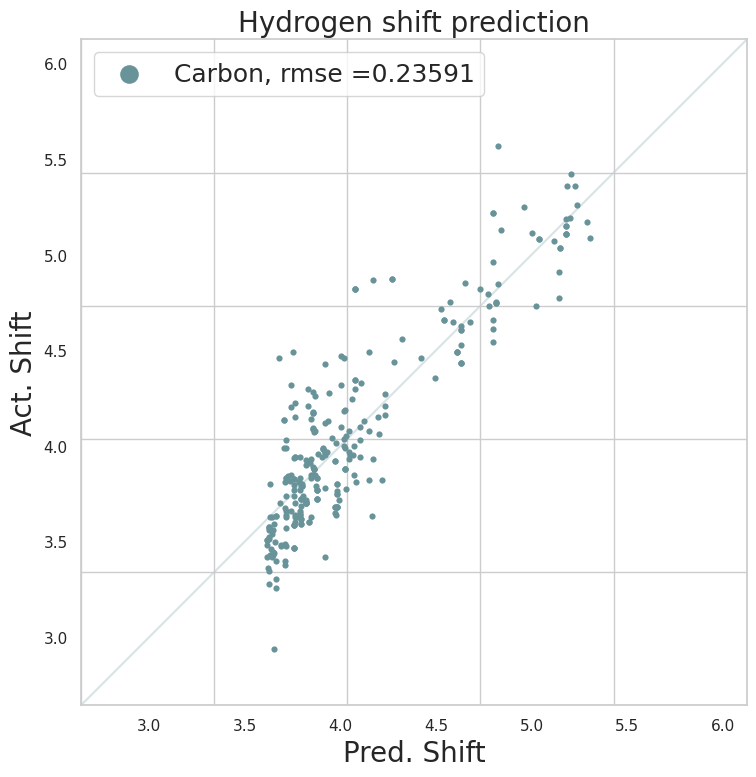

In [27]:
sns.set_theme(style="whitegrid", font_scale=1)

figure, axis = plt.subplots(1, 1, figsize=(8, 8), constrained_layout=False)
# figure, axis = plt.subplots(1, 1, figsize=(12, 12), constrained_layout=False)
# figure, axis = plt.subplots(3, 3, figsize=(8, 8))
figure.tight_layout(rect=[0, 0.03, 1, 0.95], h_pad = 1, w_pad = 1)
##### For node features
# cora
# plot_infl_feature(df1, axis, 0, 0, set_title_name='$\it{Cora}$', 
#                   xlab_name='Pred. Feat. Infl.', ylab_name = 'Act. Embed. Infl.')

# plot_shift(df_visulize_v3, axis, i = 0, set_title_name = 'Carbon Shift Prediction', sep = 5, xlab_name = 'Pred. Shift', 
#            ylab_name = 'Act. Shift', color = '#4F4536', ms = 5)
plot_shift(df_visulize_v2, axis, i = 0, set_title_name = 'Hydrogen shift prediction', sep = 5, xlab_name = 'Pred. Shift', 
           ylab_name = 'Act. Shift', color = '#679399', ms = 5)

plt.show()

In [28]:
df_visulize_v2

,0,1
0,5.115636,5.070
1,4.000951,4.320
2,3.906297,3.940
3,4.018157,4.000
4,3.868309,3.850
...,...,...
283,4.170836,3.933
284,5.306763,5.085
285,4.072030,3.849
286,4.066091,3.951


In [29]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
count_parameters(model)

234177